In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import warnings
import pip
warnings.filterwarnings("ignore")
from os import listdir
import glob

!pip install ftfy
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

#pip.main(['install','sklearn'])
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding,Bidirectional, Dropout, Activation, MaxPooling1D,Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=a872b72f493eba294c2e5f76a2decbd4a9a44cff58933b49b990af0afb328429
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ftfy


In [3]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 10000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 20000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size 
MAX_NB_WORDS = 22000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [4]:
#DEPRESSIVE_TWEETS_CSV = 'depressive_tweets.csv'
#DEPRESSIVE_TWEETS_CSV = 'depressive_tweets_processed.csv'
RANDOM_TWEETS_CSV = '/content/gdrive/My Drive/Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = '/content/gdrive/My Drive/GoogleNews-vectors-negative300.bin.gz'

In [5]:
filepaths = [f for f in listdir("/content/gdrive/My Drive/datasets") if f.endswith('.csv')]
filepaths
li = []

for filename in filepaths:
    print(filename)
    df = pd.read_csv('/content/gdrive/My Drive/datasets/' + str(filename),header=None,sep='\t',nrows = 700)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

Double_depression.csv
depression.csv
Major_depressive_disorder.csv
stress.csv
trauma.csv
panic.csv
anxiety.csv
Bipolar_Disorder.csv
PTSD.csv
Suicidal_behavior.csv
Sucide.csv
Depersonalization.csv
Psychotic_depression.csv
scale_for_depression.csv


In [6]:
frame[10]

0                                                   tweet
1           @AotDaiIy double depression for a fan of both
2       @IUsamauaf Yr asal me me groups me jata hu mer...
3             imagine being both 😔 double dépression 😔😔😔😔
4           And the @JhaSanjay is in a double depression.
                              ...                        
9795    I have managed to scale my depression back fro...
9796    A few have a little more openness of possibili...
9797    @LukeHowarthMP @reneelsamson @tegangeorge What...
9798    @ClinPsychRCW @tylerblack32 @tpamneja @J_F_Hay...
9799    54-am41 ある評価法で用いられる図を示す。この評価法はどれか。 1.BPRS  htt...
Name: 10, Length: 9800, dtype: object

In [7]:
depressive_tweets_df = frame.loc[0:DEPRES_NROWS]
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [8]:
depressive_tweets_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
1,1378305329876766721,1378052997163462659,2021-04-03 16:46:12 India Standard Time,2021-04-03,16:46:12,+0530,1322869050918146048,fmygumi,sha 🍙,NaN,@AotDaiIy double depression for a fan of both,en,[],[],[],0,0,1,[],[],https://twitter.com/fmygumi/status/13783053298...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'AotDaiIy', 'name': 'Aot Twee...",NaN,NaN,NaN,NaN
2,1378196887891812352,1378095757295816706,2021-04-03 09:35:18 India Standard Time,2021-04-03,09:35:18,+0530,1315903595049619457,ap_ka_ibrahim,ibrahim shoukat❤,NaN,@IUsamauaf Yr asal me me groups me jata hu mer...,in,[],[],[],1,0,1,[],[],https://twitter.com/ap_ka_ibrahim/status/13781...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'IUsamauaf', 'name': 'HErmit~...",NaN,NaN,NaN,NaN
3,1378104680513990659,1378104680513990659,2021-04-03 03:28:54 India Standard Time,2021-04-03,03:28:54,+0530,1304111110862311424,greedyiine,shei ⚯͛ needs jjk moots,NaN,imagine being both 😔 double dépression 😔😔😔😔,fr,[],[],[],0,1,1,[],[],https://twitter.com/greedyIine/status/13781046...,False,https://twitter.com/aotdaiiy/status/1378052997...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1378023884612542466,1378023884612542466,2021-04-02 22:07:51 India Standard Time,2021-04-02,22:07:51,+0530,401361195,inderchadha2,Inder Chadha,NaN,And the @JhaSanjay is in a double depression.,en,"[{'screen_name': 'jhasanjay', 'name': 'sanjay ...",[],[],0,0,0,[],[],https://twitter.com/InderChadha2/status/137802...,False,https://twitter.com/SureshNakhua/status/137792...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,1315685445506826243,1315685445506826243,2020-10-12 21:37:09 India Standard Time,2020-10-12,21:37:09,+0530,3853135179,lunae_lucida,lunae || local fed diana main,NaN,I have managed to scale my depression back fro...,en,[],[],[],0,0,0,[],[],https://twitter.com/lunae_lucida/status/131568...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
9796,1315658862666620928,1315658859420299264,2020-10-12 19:51:31 India Standard Time,2020-10-12,19:51:31,+0530,883019018436845570,drug_researcher,Matthew W. Johnson,NaN,A few have a little more openness of possibili...,en,[],[],[],2,0,20,[],[],https://twitter.com/Drug_Researcher/status/131...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
9797,1315595639732924426,1315204542791729152,2020-10-12 15:40:17 India Standard Time,2020-10-12,15:40:17,+0530,1200207273903017984,pherdinand2,Rev. Storm,NaN,@LukeHowarthMP @reneelsamson @tegangeorge What...,en,[],[],[],1,0,0,[],[],https://twitter.com/Pherdinand2/status/1315595...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'tegangeorge', 'name': 'Tegan...",NaN,NaN,NaN,NaN
9798,1315262655158943745,1314854593264787456,2020-10-11 17:37:08 India Standard Time,2020-10-11,17:37:08,+0530,595471027,ssolveigg,s,NaN,@ClinPsychRCW @tylerblack32 @tpamneja @J_F_Hay...,en,[],[],[],0,0,0,[],[],https://twitter.com/ssolveigg/status/131526265...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'tylerblack32', 'name': 'Tyle...",NaN,NaN,NaN,NaN


In [9]:
random_tweets_df.head(20)

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
5,6,0,Sentiment140,or i just worry too much?
6,7,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,8,0,Sentiment140,Sunny Again Work Tomorrow :-| ...
8,9,1,Sentiment140,handed in my uniform today . i miss you ...
9,10,1,Sentiment140,hmmmm.... i wonder how she my number @-)


In [10]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [11]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [12]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

depressive_tweets_arr = [x for x in depressive_tweets_df[10]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
X_d

['double depression fan',
 'yr asal groups jata hu mera depression khatam ho kahi mind change rhy ga nhi ho ga lakin ab wahan double depression hota h jo bardash nhi kr sta',
 'imagine double press',
 'and double depress',
 'double depression hits https co ef2dhx8mfc',
 'wild double depression actual thing sounds like meme really cal',
 'kimda twisted i love double depression episodes yeet appetite my normal depression atypical means i inclined binge comfort eat mdd nearly always melancholic hits rly great restrict',
 'i really want talk much really killing i cervical spondylosis affects ability function daily basis normal human along bipolar disorder dermatillomania anxiety potentially ptsd double depress',
 'yeah double depression killed also gave quadruple depression multiplied mitosis shit cant believe gon na offer hug absolutely devast',
 'double depression feature ni en tnt ps https co 0svpivtyhw',
 'i already thought life fucked well therapist told i double depression i didn t e

In [15]:
X_r

['sad apl friend',
 'i missed new moon trail',
 'omg already 7 30 o',
 'omgaga im sooo im gunna cry i dentist since 11 i suposed 2 get crown put 30min',
 'think mi bf cheating t t',
 'worry much',
 'juuuuuuuuuuuuuuuuussssst chillin',
 'sunny again work tomorrow tv tonight',
 'handed uniform today miss alreadi',
 'hmmmm wonder numb',
 'i must think posit',
 'thanks haters face day 112 102',
 'weekend sucked far',
 'jb isnt showing australia',
 'ok thats win',
 'this way feel right',
 'awhhe man i completely useless rt funny i twitter http myloc 27hx',
 'feeling strangely fine now i gon na go listen semisonic celebr',
 'huge roll thunder so scari',
 'i cut beard it growing well year i gon na start happy meantim',
 'very sad iran',
 'wompppp wompp',
 'you one see cause one else following pretty awesom',
 'sad level 3 i writing massive blog tweet myspace comp shut now lost lays fetal posit',
 'headed hospitol had pull golf tourny 3rd place i think i re ripped something yeah that',
 'boring

In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [15]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [16]:
sequences_d

[[38, 2, 798],
 [1417,
  16213,
  2313,
  1178,
  3645,
  4730,
  2,
  16214,
  983,
  10965,
  296,
  324,
  16215,
  907,
  1900,
  983,
  907,
  10966,
  6062,
  16216,
  38,
  2,
  1179,
  471,
  1514,
  16217,
  1900,
  3155,
  8466],
 [851, 38, 1154],
 [66, 38, 62],
 [38, 2, 1966, 4, 3, 16218],
 [2411, 38, 2, 1243, 125, 419, 5, 4731, 33, 1901],
 [16219,
  5281,
  1,
  19,
  38,
  2,
  778,
  10967,
  3646,
  54,
  596,
  2,
  5282,
  360,
  1,
  8467,
  3921,
  1902,
  320,
  719,
  1206,
  109,
  2044,
  1966,
  2045,
  72,
  10968],
 [1,
  33,
  39,
  170,
  52,
  33,
  1084,
  1,
  7042,
  16220,
  1819,
  2133,
  3156,
  919,
  4294,
  596,
  679,
  664,
  49,
  6,
  10969,
  14,
  3391,
  47,
  38,
  62],
 [160,
  38,
  2,
  956,
  69,
  463,
  7043,
  2,
  16221,
  16222,
  173,
  151,
  310,
  85,
  25,
  2134,
  552,
  1031,
  16223],
 [38, 2, 3157, 698, 302, 10970, 2973, 4, 3, 16224],
 [1,
  195,
  196,
  57,
  1467,
  59,
  799,
  303,
  1,
  38,
  2,
  1,
  2314,
  336

In [17]:
sequences_r

[[70, 182],
 [1, 432, 48, 978, 8116],
 [438, 195, 349, 502, 351],
 [26, 648, 26, 3370, 599, 1, 2522, 188, 752, 1, 24, 7, 3838, 241],
 [30, 871, 1425, 4434, 336, 336],
 [800, 52],
 [2520],
 [1393, 937, 31, 118, 595, 130],
 [7481, 10224, 28, 71, 1130],
 [8114, 590, 2222],
 [1, 253, 30, 3439],
 [119, 10225, 429, 8, 8117],
 [276, 3657, 327],
 [2656, 953, 1075, 2091],
 [183, 389, 306],
 [87, 78, 46, 60],
 [128, 1, 1007, 2748, 1307, 444, 1, 89, 9, 2307],
 [150, 6595, 613, 229, 1, 85, 25, 11, 577, 9862],
 [875, 2006, 3144, 91, 4239],
 [1, 615, 6080, 17, 2582, 59, 123, 1, 85, 25, 199, 93],
 [764, 70, 2217],
 [],
 [42, 12, 50, 201, 12, 370, 637, 288, 933],
 [70,
  908,
  20,
  1,
  1098,
  1310,
  980,
  200,
  1012,
  3449,
  408,
  229,
  192,
  14192,
  3439],
 [3371, 740, 2008, 5702, 2302, 498, 1, 30, 1, 3135, 6809, 139, 160, 94],
 [1137, 1019, 308, 95, 1887],
 [3484, 110, 73, 1327, 582, 57, 1202, 34, 8118, 2267],
 [5, 173, 60, 1, 33, 39, 90, 2825, 1, 20, 316, 1804, 828, 4675, 1163],
 [1239

In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 41872 unique tokens


In [19]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (9710, 140)
Shape of data_r tensor: (19898, 140)


In [20]:
data_d

array([[   0,    0,    0, ...,   38,    2,  798],
       [   0,    0,    0, ..., 1900, 3155, 8466],
       [   0,    0,    0, ...,  851,   38, 1154],
       ...,
       [   0,    0,    0, ...,    7,  544,  339],
       [   0,    0,    0, ..., 2219,  260, 4767],
       [   0,    0,    0, ...,    4,    3,  678]], dtype=int32)

In [21]:
data_r

array([[    0,     0,     0, ...,     0,    70,   182],
       [    0,     0,     0, ...,    48,   978,  8116],
       [    0,     0,     0, ...,   349,   502,   351],
       ...,
       [    0,     0,     0, ...,    59,   717,  9862],
       [    0,     0,     0, ...,  3028, 16027,  2403],
       [    0,     0,     0, ...,   758,   931,  1029]], dtype=int32)

In [22]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [37]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [24]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [25]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [26]:
# Logistic Model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

In [27]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 67.224


In [28]:
unique, counts = np.unique(labels_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 11938]
 [    1  5826]]


In [29]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))

# The first two layers with 32 filters of window size 3x3
model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(LSTM(300))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [33]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          6600000   
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 138, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 69, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 69, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 67, 64)            1

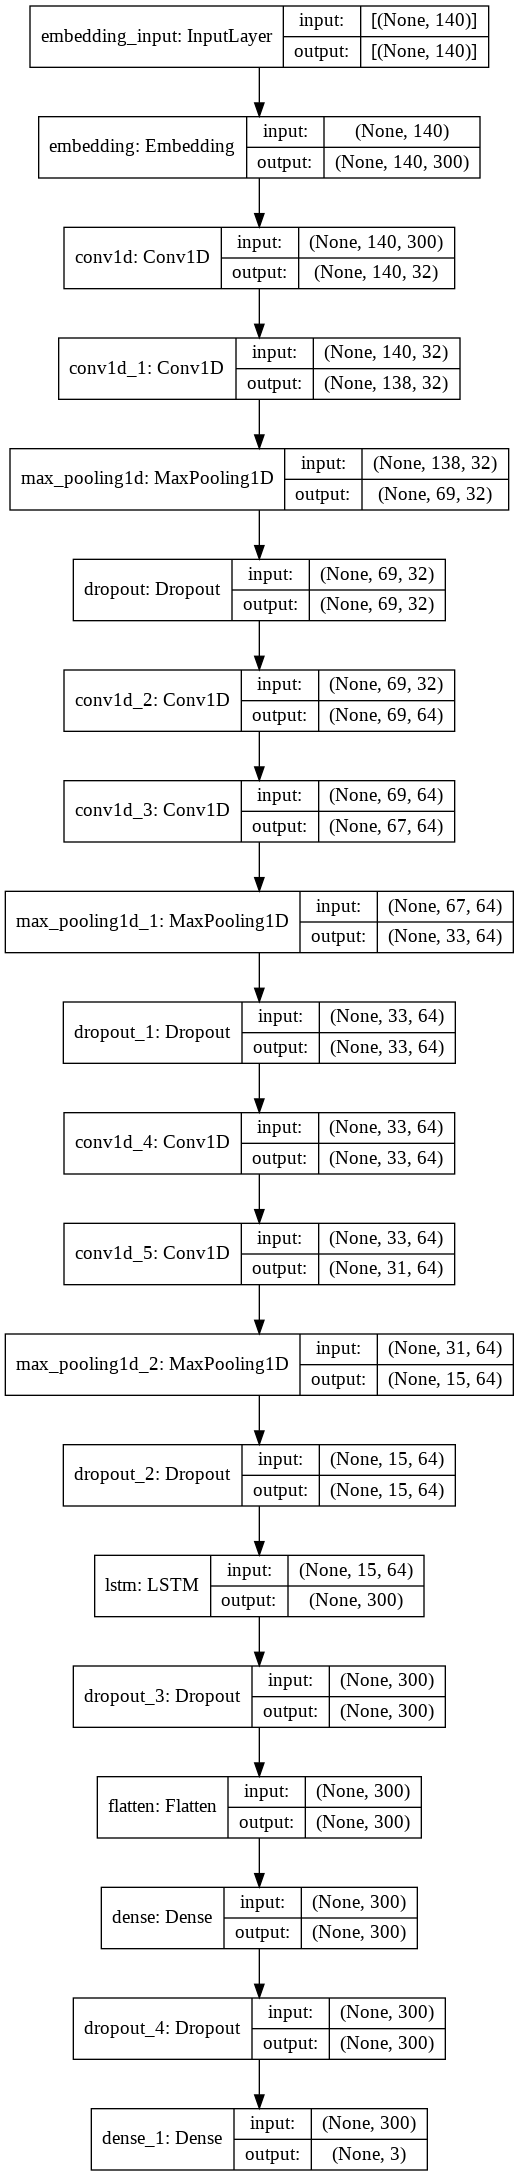

In [34]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=20, batch_size=1024, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/20
18/18 [==============================] - 53s 3s/step - loss: 0.8606 - acc: 0.6305 - val_loss: 0.4910 - val_acc: 0.7987
Epoch 2/20
18/18 [==============================] - 47s 3s/step - loss: 0.4973 - acc: 0.7983 - val_loss: 0.2994 - val_acc: 0.8921
Epoch 3/20
18/18 [==============================] - 48s 3s/step - loss: 0.2742 - acc: 0.9078 - val_loss: 0.2104 - val_acc: 0.9392
Epoch 4/20
18/18 [==============================] - 47s 3s/step - loss: 0.2017 - acc: 0.9428 - val_loss: 0.2019 - val_acc: 0.9414
Epoch 5/20
18/18 [==============================] - 47s 3s/step - loss: 0.1859 - acc: 0.9473 - val_loss: 0.2041 - val_acc: 0.9384
Epoch 6/20
18/18 [==============================] - 47s 3s/step - loss: 0.1890 - acc: 0.9444 - val_loss: 0.2131 - val_acc: 0.9318
Epoch 7/20
18/18 [==============================] - 48s 3s/step - loss: 0.1917 - acc: 0.9432 - val_loss: 0.1650 - val_acc: 0.9473
Epoch 8/20
18/18 [==============================] - 48s 3s/step - loss: 0.1531 - acc: 0.95

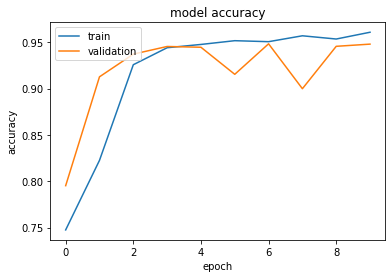

In [34]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

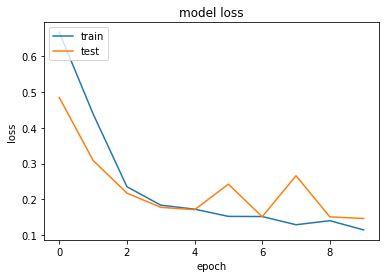

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
x = model.predict(data_test).flatten()
x.shape

(17766,)

In [37]:
labels_test.shape

(5922,)

In [38]:
class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None


    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [39]:
svm = SVM() # Linear Kernel
svm.fit(data_train, labels_train)

In [40]:
samp = svm.predict(data_test)


In [41]:
tot = len(labels_test)
cnt = 0
for i in range(tot):
    if(samp[i] == labels_test[i] or (samp[i] == -1.0 and labels_test[i] == 0)):
        cnt = cnt + 1
print(cnt/tot)

0.5557244174265451


In [51]:
x = model.predict(data_test)
x.shape

(5922, 3)

In [52]:
labels_test.shape

(5922,)